NLP : nettoyage, lemmatisation, stopwords, TF-IDF

Machine Learning : classification, clustering

Visualisation : WordCloud, matplotlib

Regex : nettoyage du texte

In [2]:
# Imports et installation
!pip install datasets scikit-learn nltk wordcloud matplotlib


In [3]:
# Imports des librairies
import re
import pandas as pd
import nltk
from datasets import load_dataset
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import classification_report, confusion_matrix
from wordcloud import WordCloud
import matplotlib.pyplot as plt

In [4]:
# Télécharger les ressources nécessaires à NLTK (à faire une seule fois)
nltk.download("punkt") # punkt : pour découper le texte en mots (tokenisation)
nltk.download('punkt_tab')
nltk.download("stopwords") # liste de mots à exclure.
nltk.download("wordnet") # dictionnaire linguistique pour la lemmatisation

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package punkt_tab to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt_tab.zip.
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...


True

In [5]:
# chargement du dataset medical

from datasets import load_dataset

# Charger le dataset depuis Hugging Face
dataset = load_dataset("AchOk78/LLMgenerated_fictive_medical_report_and_summaries_with_omissions_label_Fr_Healthcare")

# Afficher un aperçu du contenu
print(dataset)

# On prend uniquement la partie "train" pour simplifier
df = pd.DataFrame(dataset["train"])
print("Aperçu du dataset :")
print(df.head())


/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


README.md: 0.00B [00:00, ?B/s]

synthetic%20data.json: 0.00B [00:00, ?B/s]

Generating train split:   0%|          | 0/3 [00:00<?, ? examples/s]

DatasetDict({
    train: Dataset({
        features: ['doc_id', 'fictive_cr', 'summary', 'omissions'],
        num_rows: 3
    })
})
Aperçu du dataset :
   doc_id                                         fictive_cr  \
0       2  CR : _____<br>Motif  d’hospitalisation :<br>In...   
1       3  CR : _____<br>Motif d’hospitalisation :<br>Ins...   
2       4  CR : _____<br>Motif d'HOSPITALISATION :<br>Sur...   

                                             summary  omissions  
0  Le patient a été hospitalisé en soins intensif...          0  
1  Le patient, un octogénaire avec des antécédent...          0  
2  Le patient, un ancien ingénieur non fumeur, re...          0  


|
| **`doc_id`** = Identifiant du document                                                                                              |
| **`fictive_cr`** = Le **compte rendu médical complet** (texte brut)                                          | 🧠 **C’est notre variable d’entrée X**                      |
| **`summary`**  = Un résumé du compte rendu                                                                 | Peut servir dans d’autres tâches (résumé automatique, etc.) |
| **`omissions`**  = Un **label binaire** (0 ou 1) indiquant s’il y a des omissions dans le résumé ou le texte | 🎯 **C’est notre variable cible y**                         |


In [6]:

# Nettoyage du texte
stop_words = set(stopwords.words("french"))
lemmatizer = WordNetLemmatizer()

def nettoyer_texte(texte):
    texte = texte.lower()
    # Nettoyage du texte : on garde les lettres et caractères français
    texte = re.sub(r"[^a-zA-Zàâçéèêëîïôûùüÿñæœ'\s-]", " ", texte)
    tokens = nltk.word_tokenize(texte)
    tokens = [lemmatizer.lemmatize(mot) for mot in tokens if mot not in stop_words and len(mot) > 2]
    return " ".join(tokens)

# Appliquer le nettoyage sur la colonne 'report' (texte principal)
df["texte_nettoye"] = df["fictive_cr"].apply(nettoyer_texte)
print("Texte nettoyé :")
print(df["texte_nettoye"].head())

Texte nettoyé :
0    motif hospitalisation insuffisance pancréatiqu...
1    motif hospitalisation insuffisance hépatique a...
2    motif d'hospitalisation surveillance post opér...
Name: texte_nettoye, dtype: object


la tokenization word_tokenize utilise une ressource supp appelé punkt-tab
texte = re.sub(r"<br\s*/?>", " ", texte) = pour enlever les balises HTML


Nettoyage des textes dans la colonne report en :

mettant en minuscules

supprimant la ponctuation

enlevant les stopwords = les mots vides (le, la, les, de, des, à, en, du, il, elle, nous, vous, est, sont, etc)

lemmatisant les mots = réduction à la racine (consiste à ramener un mot à sa forme canonique (le lemme), c'est-à-dire sa forme de base, sans perdre le sens. Ex : mangeaient -> manger, patients -> patient

Sans lemmatisation : "patients", "patient", "patiente" → 3 mots différents
Avec lemmatisation : "patient" → 1 seul mot

In [6]:
Exemple avec les CR en anglais
import re    # bibliothèque de regex (expressions régulières), pour nettoyer le texte.
import nltk  # bibliothèque NLP de base
from nltk.corpus import stopwords # liste de mots inutiles à retirer
from nltk.stem import WordNetLemmatizer # outil de lemmatisation (ramène les mots à leur racine grammaticale)

# Télécharger les ressources nécessaires à NLTK (à faire une seule fois)
nltk.download("punkt") # punkt : pour découper le texte en mots (tokenisation)
nltk.download("stopwords") # liste de mots à exclure.
nltk.download("wordnet") # dictionnaire linguistique pour la lemmatisation

# Initialisation
stop_words = set(stopwords.words("french")) # crée un ensemble (set) des mots vides en français
lemmatizer = WordNetLemmatizer() # initialise un objet pour lemmatiser les mots

# Fonction de nettoyage appelée nettoyer_texte, qui prendra une chaîne de caractères (texte brut) et la retournera nettoyée
def nettoyer_texte(texte):
    texte = texte.lower() # mettre tout le texte en minuscules
    texte = re.sub(r"[^a-zA-Zàâçéèêëîïôûùüÿñæœ\s]", " ", texte)  # Le [^...] signifie : "Tout ce qui n’est PAS dans cette liste" doit être supprimé (ou remplacé ici par un espace " ").Enlever les caractères spéciaux (ne garde que les lettres françaises et les espaces)
    tokens = nltk.word_tokenize(texte) # Découpe le texte en mots individuels (appelés tokens). Ex: "le patient vient demain" → ["le", "patient", "vient", "demain"]
    tokens = [lemmatizer.lemmatize(mot) for mot in tokens if mot not in stop_words and len(mot) > 2] # if mot not in stop_words = enlève les mots inutiles (ex : "le", "et", "est")
    # len(mot) > 2 = garde les mots qui ont 3 caractères ou plus
    # lemmatizer.lemmatize(mot) transforme chaque mot en sa forme de base
    return " ".join(tokens) # Recolle tous les mots nettoyés en une seule chaîne de texte (séparés par un espace)


SyntaxError: invalid syntax (ipython-input-1210661306.py, line 1)

C’est une façon rapide de créer une nouvelle liste à partir d’une autre, avec des filtres et des transformations : tokens = [lemmatizer.lemmatize(mot) for mot in tokens if mot not in stop_words and len(mot) > 2]

si le mot n’est pas dans les stopwords,

et si sa longueur est supérieure à 2 caractères,
→ alors on le lemmatise (on le transforme en sa forme de base)
→ et on l’ajoute à la nouvelle liste tokens.

In [7]:
# Vectorisation TF-IDF (Transforme les textes en vecteurs numériques avec TF-IDF pour que le modèle de machine learning puisse comprendre le langage)
vectorizer = TfidfVectorizer(max_features=1000) # on garde uniquement les 1 000 mots les plus importants du corpus
X = vectorizer.fit_transform(df["texte_nettoye"]) # transform = il convertit chaque texte en un vecteur numérique, fit()= le vectorizer analyse tous les textes et apprend la liste des mots utiles

Si tu as 500 rapports médicaux et 1000 mots sélectionnés :
X.shape = (500, 1000)


In [8]:
# Classification supervisée (Entraîne un modèle Naive Bayes pour prédire le label omission_label)

# Ici, on utilise la colonne 'omission_label' comme étiquette (peut être 0 ou 1)
y = df["omissions"]

# Découper en train/test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Entraînement d’un modèle Naive Bayes
model = MultinomialNB()
model.fit(X_train, y_train)

# Prédictions
y_pred = model.predict(X_test)

# Rapport de classification
print("\n=== Rapport de classification ===")
print(classification_report(y_test, y_pred))

# Matrice de confusion
print("\n=== Matrice de confusion ===")
print(confusion_matrix(y_test, y_pred))


=== Rapport de classification ===
              precision    recall  f1-score   support

           0       1.00      1.00      1.00         1

    accuracy                           1.00         1
   macro avg       1.00      1.00      1.00         1
weighted avg       1.00      1.00      1.00         1


=== Matrice de confusion ===
[[1]]


/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:407: UserWarning: A single label was found in 'y_true' and 'y_pred'. For the confusion matrix to have the correct shape, use the 'labels' parameter to pass all known labels.
  warnings.warn(


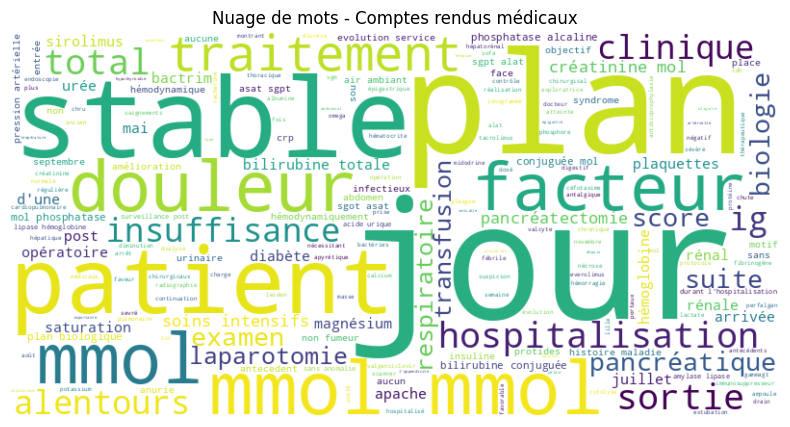

In [9]:
# Visualisation (world cloud)

text = " ".join(df["texte_nettoye"])
wordcloud = WordCloud(width=800, height=400, background_color="white").generate(text)

plt.figure(figsize=(10,5))
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis("off")
plt.title("Nuage de mots - Comptes rendus médicaux")
plt.show()

In [12]:
# Clustering

from sklearn.cluster import KMeans

kmeans = KMeans(n_clusters=3, random_state=42)
df["cluster"] = kmeans.fit_predict(X)

print("\nAperçu du clustering :")
print(df[["fictive_cr", "cluster"]].head(10))


Aperçu du clustering :
                                          fictive_cr  cluster
0  CR : _____<br>Motif  d’hospitalisation :<br>In...        2
1  CR : _____<br>Motif d’hospitalisation :<br>Ins...        0
2  CR : _____<br>Motif d'HOSPITALISATION :<br>Sur...        1


à l'index 0, le texte appartient au cluster 2
Chaque cluster regroupe des textes jugés similaires par KMeans selon les vecteurs contenus dans X.
Le df ne contient que 3 lignes. Pour que le clustering soient utiles, il faut plus de textes. 3 lignes de textes correponds à 3 CR médicaux.

In [13]:
print("\n Projet NLP médical terminé avec succès !")


 Projet NLP médical terminé avec succès !


classification = quel type de texte est ce ?
clustering = quel texte se ressemble entre eux ?